In [ ]:
import torch
import random
import numpy as np

random.seed(0)#номер последовательности случайных чисел
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)#для куда
torch.backends.cudnn.deterministic = True#детерминистичный режим (воспроизводимый)

In [ ]:
import sklearn.datasets
wine = sklearn.datasets.load_wine()
wine.data.shape

(178, 13)

In [ ]:
from sklearn.model_selection import train_test_split#делим датасет на тренировочный и тестовый.

X_train, X_test, y_train, y_test = train_test_split(
    wine.data[:, :2],#передаем датасет, используем только две колонки для удобной визуализации
    wine.target,#классы, которые надо предсказать, номер класса
    test_size=0.3,#треть в тест
    shuffle=True)#перемешать прежде чем делить

#оборачиваем в тензоры
X_train = torch.FloatTensor(X_train)
X_test = torch.FloatTensor(X_test)#флот - дробные
y_train = torch.LongTensor(y_train)#лонг - недробные
y_test = torch.LongTensor(y_test)

In [ ]:
class WineNet(torch.nn.Module):
    def __init__(self, n_hidden_neurons):
        super(WineNet, self).__init__()

        self.fc1 = torch.nn.Linear(2, n_hidden_neurons)#2 колонки для каждой бутылки вина
        self.activ1 = torch.nn.Sigmoid()
        self.fc2 = torch.nn.Linear(n_hidden_neurons, n_hidden_neurons)
        self.activ2 = torch.nn.Sigmoid()
        self.fc3 = torch.nn.Linear(n_hidden_neurons, 3)#3 класса вина, заранее знаем
        self.sm = torch.nn.Softmax(dim=1)#передаем числа в софтмакс чтобы получить вероятности классов


    def forward(self, x):#почему не прогоням выход из третьего слоя через софтмакс? надо прогнать через см и посчитать бинарную кросс энтропию. но в бинарной кросс энтропии логарифм, а в софтмаксе экспоненты. они взаимно уничтожаются. можем посчитать бкэ без см.#т.е. для подсчета лоссов см не нужен. он нужен для вероятности
        x = self.fc1(x)
        x = self.activ1(x)
        x = self.fc2(x)
        x = self.activ2(x)
        x = self.fc3(x)
        return x

    def inference(self, x):
        x = self.forward(x)
        x = self.sm(x)
        return x

wine_net = WineNet(5)

In [ ]:
#loss - BCE. использует выходы нс, не пропущенные через см
loss = torch.nn.CrossEntropyLoss()
#метод для вычисления градиентных шагов
optimizer = torch.optim.Adam(wine_net.parameters(), lr=1.0e-3)#lr одна тысячная говорит ее выбирать, близко к оптимуму скорее всего

обычно в память не помещается весь датасет, поэтому при обучении берем его батчами. 1 батч на 1 эпоху

In [ ]:
np.random.permutation(5)

array([2, 0, 1, 4, 3])

In [ ]:
batch_size = 10

for epoch in range(5000):
    order = np.random.permutation(len(X_train))
    for start_index in range(0, len(X_train), batch_size):
        optimizer.zero_grad()

        batch_indexes = order[start_index:start_index+batch_size]

        x_batch = X_train[batch_indexes]
        y_batch = y_train[batch_indexes]

        preds = wine_net.forward(x_batch)

        loss_value = loss(preds, y_batch)
        loss_value.backward()

        optimizer.step()

    if epoch % 100 == 0:#каждые сто эпох считаем метрики и смотрим, обучается ли нс
        test_preds = wine_net.forward(X_test)
        test_preds = test_preds.argmax(dim=1)
        print((test_preds == y_test).float().mean())

tensor(0.4074)
tensor(0.4074)
tensor(0.4630)
tensor(0.5000)
tensor(0.4259)
tensor(0.4074)
tensor(0.5185)
tensor(0.5185)
tensor(0.4444)
tensor(0.4259)
tensor(0.5000)
tensor(0.5370)
tensor(0.5370)
tensor(0.5370)
tensor(0.7407)
tensor(0.6852)
tensor(0.6481)
tensor(0.6852)
tensor(0.6667)
tensor(0.6852)
tensor(0.6852)
tensor(0.6852)
tensor(0.7222)
tensor(0.7037)
tensor(0.7407)
tensor(0.7593)
tensor(0.7778)
tensor(0.7963)
tensor(0.8148)
tensor(0.8148)
tensor(0.8148)
tensor(0.8148)
tensor(0.8333)
tensor(0.8148)
tensor(0.8333)
tensor(0.8333)
tensor(0.8333)
tensor(0.8333)
tensor(0.8519)
tensor(0.8519)
tensor(0.8519)
tensor(0.8519)
tensor(0.8519)
tensor(0.8519)
tensor(0.8519)
tensor(0.8519)
tensor(0.8519)
tensor(0.8519)
tensor(0.8519)
tensor(0.8519)


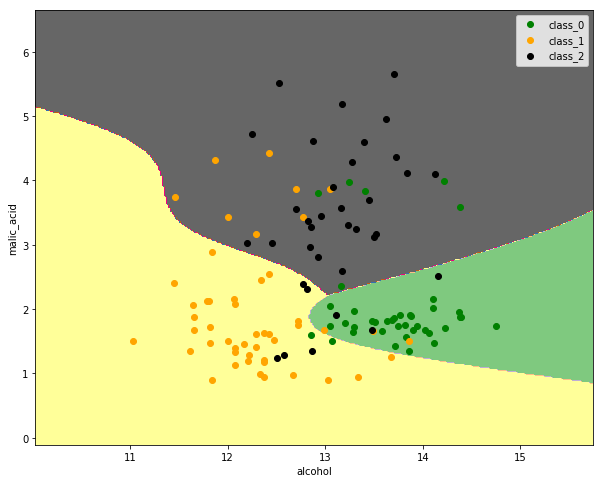

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams['figure.figsize'] = (10, 8)

n_classes = 3
plot_colors = ['g', 'orange', 'black']
plot_step = 0.02

x_min, x_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
y_min, y_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1

xx, yy =  torch.meshgrid(torch.arange(x_min, x_max, plot_step),
                         torch.arange(y_min, y_max, plot_step))

preds = wine_net.inference(
    torch.cat([xx.reshape(-1, 1), yy.reshape(-1, 1)], dim=1))

preds_class = preds.data.numpy().argmax(axis=1)
preds_class = preds_class.reshape(xx.shape)
plt.contourf(xx, yy, preds_class, cmap='Accent')

for i, color in zip(range(n_classes), plot_colors):
    indexes = np.where(y_train == i)
    plt.scatter(X_train[indexes, 0],
                X_train[indexes, 1],
                c=color,
                label=wine.target_names[i],
                cmap='Accent')
    plt.xlabel(wine.feature_names[0])
    plt.ylabel(wine.feature_names[1])
    plt.legend()